In [4]:
%load_ext autoreload
%autoreload 2.0
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np

In [6]:
import sys
sys.path.insert(0, '../.')

In [7]:
from data.detection_dataset_loader import *

/Users/apple/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [102]:
import numpy as np
import math
from scipy.ndimage import rotate
import cv2
from data.data_utils.fv_utils import *

def in_range_points(points, x, y, z, x_range, y_range, z_range):
    """ 
    This function is imported from https://github.com/windowsub0406/KITTI_Tutorial/blob/master/Convert_Velo_2_Topview_detail.ipynb
    extract in-range points 
    """
    return points[np.logical_and.reduce((x >= x_range[0], x <= x_range[1], y >= y_range[0], \
                                         y <= y_range[1], z >= z_range[0], z <= z_range[1]))]

def rotateImage(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

def velo_points_bev2(points, x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
                    size=(512, 448, 40), img_width=1224, img_height=370, translate_x=0, translate_y=0, translate_z = 0, ang=0):
   
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]

    x_lim = in_range_points(x, x, y, z, x_range, y_range, z_range)
    y_lim = in_range_points(y, x, y, z, x_range, y_range, z_range)
    z_lim = in_range_points(z, x, y, z, x_range, y_range, z_range)

    x_lim -= translate_x
    y_lim -= translate_y
    z_lim -= translate_z
    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    z_range = (z_range[0] + translate_z, z_range[1] + translate_z)

    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
        
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size

    # if x_range[0] < 0:
    x_lim = x_lim + -1*x_range[0]
    # if y_range[0] < 0:
    y_lim = y_lim + -1*y_range[0]
    # if z_range[0] < 0:
    z_lim = z_lim + -1*z_range[0]
        
    x_lim = -1 * (x_lim * x_fac).astype(np.int32)
    y_lim = -1 * (y_lim * y_fac).astype(np.int32)
    z_lim = 1 * (z_lim * z_fac).astype(np.int32)

    x_lim2 = x_lim[:]
    y_lim2 = y_lim[:]
    z_lim2 = z_lim[:]

    x_lim = x_lim[(x_lim2>-size[0]) & (x_lim2<= 0) & (y_lim2>-size[1]) & (y_lim2 <= 0) & (z_lim2<size[2]) & (z_lim2 >= 0)]
    y_lim = y_lim[(x_lim2>-size[0]) & (x_lim2<= 0) & (y_lim2>-size[1]) & (y_lim2 <= 0) & (z_lim2<size[2]) & (z_lim2 >= 0)]
    z_lim = z_lim[(x_lim2>-size[0]) & (x_lim2<= 0) & (y_lim2>-size[1]) & (y_lim2 <= 0) & (z_lim2<size[2]) & (z_lim2 >= 0)]

    
    img = np.zeros([size[0], size[1], size[2]], dtype=np.uint8)
    # occupancy grid
    img[x_lim, y_lim, z_lim] = 255
    if ang != 0:
        # img = rotate(img, ang, reshape=False)
        img = rotateImage(img, ang)
        img[img<255//2]=0
        img[img>=255//2]=255.
    return img

In [8]:
base_path = '/Users/apple/Desktop/Master/Data/'

In [9]:
eval_dataset = DetectionDatasetLoader(base_path, None, 0.8, 42, False)

In [11]:
data = eval_dataset.get_next(batch_size=1)
       
camera_tensor, lidar_tensor, label_tensor, Tr_velo_to_cam, R0_rect, P3, shift_h, shift_w = data

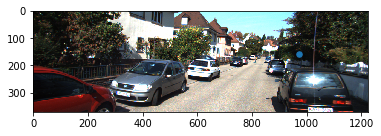

In [164]:
# plt.scatter([400], [200], s=30)
plt.scatter([970.2348], [158.5476], s=30)
plt.imshow(camera_tensor[0])
plt.show()

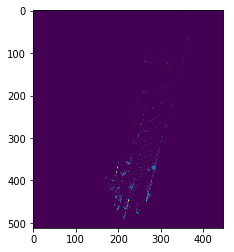

In [163]:
img = np.clip(np.mean(lidar_tensor[0, :, :, 13:], 2), 0, 1)
plt.scatter([281], [369], s=10)
plt.imshow(img)
plt.show()

In [151]:
new_velo = velo_points_bev2(np.array(pp))
new_velo = velo_points_bev2(np.array([[20,   -10,    0.5 ]]))

In [152]:
new_velo.shape

(512, 448, 40)

In [153]:
np.where(new_velo>0)

(array([369]), array([281]), array([34]))

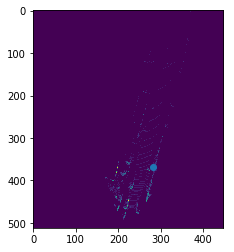

In [162]:
img = np.clip(np.mean(lidar_tensor[0, :, :, :], 2), 0, 1)
plt.scatter([281], [369])
plt.imshow(img)
plt.show()

In [14]:
Tr_velo_to_cam.shape

(1, 4, 4)

In [15]:
R0_rect.shape

(1, 4, 4)

In [16]:
P3.shape

(1, 3, 4)

In [24]:
P3_inv = np.linalg.pinv(P3[0])
R0_rect_inv = np.linalg.pinv(R0_rect[0])
Tr_velo_to_cam_inv = np.linalg.pinv(Tr_velo_to_cam[0])

In [27]:
P3_inv = P3_inv.reshape((1, 4, 3))
R0_rect_inv = R0_rect_inv.reshape((1, 4, 4))
Tr_velo_to_cam_inv = Tr_velo_to_cam_inv.reshape((1, 4, 4))

In [30]:
def project_point_from_camera_coor_to_img_coor(point, Tr_velo_to_cam, R0_rect, P3):
    img_point = P3.dot(R0_rect.dot(Tr_velo_to_cam.dot(point)))
    return img_point

def project_point_from_lidar_to_image(point, Tr_velo_to_cam, R0_rect, P3):
    point = tf.reshape(point, (-1, 4, 1))
    Tr_velo_to_cam2 = tf.reshape(Tr_velo_to_cam, (1, 4, 4))
    x = tf.matmul(tf.cast(Tr_velo_to_cam2, tf.float32), tf.cast(point, tf.float32))
    R0_rect2 = tf.reshape(R0_rect, (-1, 4, 4))
    x2 = tf.matmul(tf.cast(R0_rect2, tf.float32), x)
    P3_2 = tf.reshape(P3, (-1, 3, 4))
    rgb_point = tf.matmul(tf.cast(P3_2, tf.float32), x2)
#     return rgb_point[:, :2, 0]
    return rgb_point[:, :2, 0] / rgb_point[:, 2, 0]

In [33]:
def project_point_from_image_to_lidar(point, Tr_velo_to_cam, R0_rect, P3):
    point = tf.reshape(point, (-1, 3, 1))
    x = tf.matmul(tf.cast(P3, tf.float32), tf.cast(point, tf.float32))
    x2 = tf.matmul(tf.cast(R0_rect, tf.float32), x)
    lidar_point = tf.matmul(tf.cast(Tr_velo_to_cam, tf.float32), x2)
    return lidar_point[:, :3, 0] / lidar_point[:, 3, 0]

In [141]:
point = project_point_from_lidar_to_image(np.array([  20,   -10,    0.5,   0.]), Tr_velo_to_cam, R0_rect, P3)




In [142]:
with tf.Session() as sess:
    print(sess.run(point))

[[970.2348 158.5476]]


In [125]:
point_l = project_point_from_image_to_lidar(np.array([  400., 200.,  1]), Tr_velo_to_cam_inv, R0_rect_inv, P3_inv)

In [126]:
pp = None

In [127]:
with tf.Session() as sess:
    pp = sess.run(point_l)
    print(pp)

[[-68.25342   -19.872976    1.5788612]]


In [124]:
with tf.Session() as sess:
    pp = sess.run(point_l)
    print(pp)

[[-25.119776 -17.881962   0.42823 ]]
